## Survey Mask and Ultrafast Correlation Functions

This notebook presents the `Survey Mask and Ultrafast Correlation Functions` project.

It in progress under the LINCC Frameworks Incubators Program, and is an ideal use case of integration with HiPSCat/LSDB.

### What is Gundam?

[Gundam](https://github.com/lincc-frameworks-mask-incubator/gundam) is a scientific package that computes __2-point correlation functions__ for large galaxy catalogs. 

Given a set separation bins, it computes the distance between each pair of galaxies in the catalog and increments the counts in the respective distance bins. The result is an histogram of counts, which can then be sent to an estimator. 

It features `angular`, `projected` and `redshift`-space coordinates.

### Challenges

- Gundam loads entire catalogs into memory. It does not scale for multi-terabyte-sized catalogs of the likes of LSST.
- We want to ignore undesired effects from the catalogs (e.g. created by survey discontinuities, bright stars, cosmic dust) when calculating the correlation function estimates. As such, we need to apply masks to the catalogs.

### Added value with LSDB

- It has parallel processing capabilities. 
- It is easy to set up in cloud computing systems and HPCs, and it has continuous support.
- We can leverage the HiPSCat format to perform counts on pairs of spatially-correlated partitions.
- We can perform operations with masks (union of masks and galaxy filtering) efficiently using HEALPix.

### Current achievements

We have been working on this incubator for a month. Here is what we achieved so far.

__We updated the Gundam package__

- Gundam was developed ~7 years ago and it contains both Python and Fortran source code. 
- Its building process was cumbersome because its requirements were out-of-date: using it with LSDB would not be trivial.
- We introduced it to the `scikit-build-core` build system and started supporting `Python 3.9` and above.
- We set up automated deployments on PyPI (`pip install gundam`).

__We created [corrgi](https://github.com/lincc-frameworks-mask-incubator/corrgi) (Correlation with Gundam Improved)__

- `corrgi` is a package that allows Gundam to interface with LSDB.
- It calls the Fortran subroutines to perform countings for pairs of partitions.
- It wraps the available estimators for both auto and cross correlation.

In [1]:
from dask.distributed import Client

client = Client(n_workers=3, threads_per_worker=1)

#### Auto-correlation

Let's compute the angular auto-correlation function for a small catalog of galaxy samples.

In [2]:
import lsdb

# Load the galaxy and random sample catalogs in HiPSCat format
galaxy_catalog = lsdb.read_hipscat("hipscat/DATA")
random_catalog = lsdb.read_hipscat("hipscat/RAND")

In [3]:
print(f"Num galaxy samples: {galaxy_catalog.hc_structure.catalog_info.total_rows}")
print(f"Num random samples: {random_catalog.hc_structure.catalog_info.total_rows}")

Num galaxy samples: 84383
Num random samples: 227336


In [4]:
from gundam import gundam

# Define parameters for the angular auto-correlation (acf)
acf_params = gundam.packpars(kind="acf")
acf_params.dsept = 0.1 # Bin separation
acf_params.nsept = 33 # Number of bins
acf_params.septmin = 0.01 # Minimum separation

Missing outfn: default to run001


The `compute_autocorrelation` interface allows us to compute the 2-point function estimate for any type of auto-correlation. We just need to provide the respective `corrgi` class type and the respective parameters. By default, we use the natural estimator (`DD/RR - 1`).

In [5]:
%%time

from corrgi.correlation.angular_correlation import AngularCorrelation
from corrgi.corrgi import compute_autocorrelation

estimate = compute_autocorrelation(galaxy_catalog, random_catalog, AngularCorrelation, params=acf_params)

CPU times: user 707 ms, sys: 275 ms, total: 982 ms
Wall time: 1min 7s


In [6]:
estimate

array([ 9.67727557e+00,  8.27245464e+00,  6.79223294e+00,  6.31406745e+00,
        5.16505684e+00,  4.56687058e+00,  3.81708265e+00,  3.38042360e+00,
        2.89836580e+00,  2.50745582e+00,  2.13714165e+00,  1.74879659e+00,
        1.52397803e+00,  1.23825053e+00,  1.01070238e+00,  7.88735318e-01,
        6.36294902e-01,  5.11949215e-01,  4.11617827e-01,  3.43233898e-01,
        2.88660879e-01,  2.46688398e-01,  2.06456751e-01,  1.70027183e-01,
        1.44459645e-01,  1.15766443e-01,  8.80028832e-02,  6.63683593e-02,
        5.27446582e-02,  3.65372669e-02,  1.24337597e-02, -8.29080496e-03,
       -2.23599650e-02])

When computing the result we can open the Dask dashboard and check that there are tasks for:

- Loading the parquet partition files (`read_parquet`)
- Counting the pairs of galaxies within the same partition (`count_auto`)
- Counting the pairs of galaxies residing in different partitions (`count_cross`) 
- Adding the partial count histograms (`add`)

<img src="dask-dashboard.jpg" height="500">

In [7]:
import numpy as np
import numpy.testing as npt

expected_acf_nat_estimate = np.load("expected_results/acf/w_acf_nat.npy")
npt.assert_allclose(estimate, expected_acf_nat_estimate, rtol=1e-7)

#### Cross-correlation

We can also compute the cross-correlation for two catalogs using the `compute_crosscorrelation` interface. 

However, this time, we'll have a look at a projected type of correlation (which requires redshift information), and analyze the result of the `compute_crosscorrelation_counts` routine to check the counts for each bin.

In [8]:
import lsdb

# Load the galaxies and random sample catalogs in HiPSCat format
galaxy_catalog_1 = lsdb.read_hipscat("hipscat/pcf_gals_weight")
galaxy_catalog_2 = lsdb.read_hipscat("hipscat/pcf_gals1_weight")
random_catalog = lsdb.read_hipscat("hipscat/pcf_rans_weight")

In [9]:
galaxy_catalog_1.columns

Index(['ra', 'dec', 'z', 'wei', 'Norder', 'Dir', 'Npix'], dtype='object')

In [10]:
print(f"Num galaxy samples (catalog 1): {galaxy_catalog_1.hc_structure.catalog_info.total_rows}")
print(f"Num galaxy samples (catalog 2): {galaxy_catalog_2.hc_structure.catalog_info.total_rows}")
print(f"Num random samples: {random_catalog.hc_structure.catalog_info.total_rows}")

Num galaxy samples (catalog 1): 84383
Num galaxy samples (catalog 2): 35924
Num random samples: 227336


In [11]:
from gundam import gundam

# Define parameters for the projected cross-correlation (pccf)
pccf_params = gundam.packpars(kind="pccf")
pccf_params.nsepp = 28  # Number of bins of projected separation rp
pccf_params.seppmin = 0.02  # Minimum rp in Mpc/h
pccf_params.dsepp = 0.12  # Bin size of rp (in log space)
pccf_params.nsepv = 1  # Number of bins of LOS separation pi
pccf_params.dsepv = 40.0  # Bin size of pi (in linear space)
pccf_params.omegam = 0.25  # Omega matter
pccf_params.omegal = 0.75  # Omega lambda
pccf_params.h0 = 100  # Hubble constant [km/s/Mpc]

Missing outfn: default to run001


In [12]:
from corrgi.correlation.projected_correlation import ProjectedCorrelation

# Use the galaxies weight information
correlation = ProjectedCorrelation(params=pccf_params, use_weights=True)

# Bins of projected separation
correlation.sepp

array([2.00000000e-02, 2.63651348e-02, 3.47560166e-02, 4.58173531e-02,
       6.03990344e-02, 7.96214341e-02, 1.04961492e-01, 1.38366194e-01,
       1.82402168e-01, 2.40452887e-01, 3.16978638e-01, 4.17859226e-01,
       5.50845741e-01, 7.26156110e-01, 9.57260185e-01, 1.26191469e+00,
       1.66352754e+00, 2.19295639e+00, 2.89087954e+00, 3.81092144e+00,
       5.02377286e+00, 6.62262243e+00, 8.73031664e+00, 1.15087987e+01,
       1.51715515e+01, 2.00000000e+01, 2.63651348e+01, 3.47560166e+01,
       4.58173531e+01])

In [13]:
%%time

from corrgi.dask import compute_crosscorrelation_counts

counts_cd, counts_cr = compute_crosscorrelation_counts(galaxy_catalog_1, galaxy_catalog_2, random_catalog, correlation)

CPU times: user 475 ms, sys: 148 ms, total: 622 ms
Wall time: 24.7 s


In [14]:
counts_cd

array([[7.47601435e+00, 2.10221375e+01, 2.25870395e+01, 3.83632316e+01,
        8.28439191e+01, 1.26790853e+02, 2.53672565e+02, 3.94949601e+02,
        7.63710199e+02, 1.23428300e+03, 2.09980287e+03, 3.73556326e+03,
        6.31803369e+03, 1.11069153e+04, 1.95938736e+04, 3.38798332e+04,
        5.93326315e+04, 1.02018384e+05, 1.76154654e+05, 3.03063270e+05,
        5.23083655e+05, 8.87799169e+05, 1.52688273e+06, 2.59414711e+06,
        4.38565358e+06, 7.29387936e+06, 1.19860308e+07, 1.94952626e+07]])

Text(0, 0.5, 'Counts')

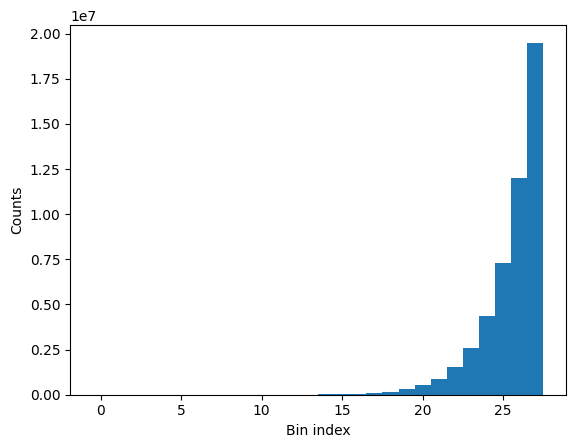

In [15]:
import matplotlib.pyplot as plt

plt.bar(np.arange(correlation.params.nsepp), counts_cd.flatten(), width=1)
plt.xlabel('Bin index')
plt.ylabel('Counts')

In [16]:
counts_cr

array([[2.53769731e+01, 4.11379811e+01, 6.79430568e+01, 1.26356072e+02,
        2.28818417e+02, 3.70669620e+02, 6.59324998e+02, 1.12231840e+03,
        1.98618235e+03, 3.44177275e+03, 5.88003805e+03, 1.03359510e+04,
        1.79192358e+04, 3.09492997e+04, 5.36127924e+04, 9.22974877e+04,
        1.59114610e+05, 2.75896892e+05, 4.75095762e+05, 8.19559078e+05,
        1.41531484e+06, 2.42835517e+06, 4.15313442e+06, 7.06421317e+06,
        1.19432701e+07, 2.00233118e+07, 3.30265872e+07, 5.32131870e+07]])

Text(0, 0.5, 'Counts')

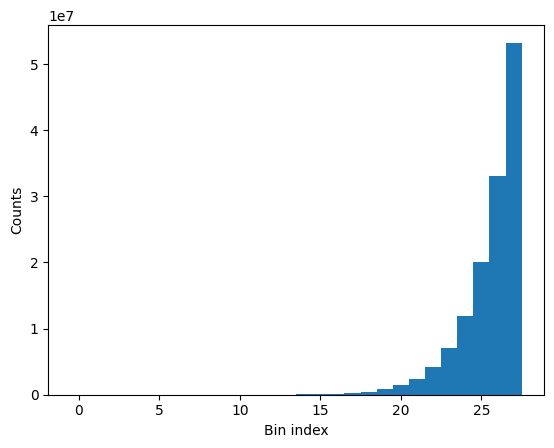

In [17]:
plt.bar(np.arange(correlation.params.nsepp), counts_cr.flatten(), width=1)
plt.xlabel('Bin index')
plt.ylabel('Counts')

In [18]:
client.shutdown()

### Upcoming improvements/features

1. Cone optimizations. The goal is to use cone search operations to determine if entire HiPSCat partitions live within the same distance bin for the correlation. If they do, we can avoid performing any distance calculations for galaxies in those pairs.

<img src="cone-optimization.png" height="500">

2. Import masks in HiPSCat format and implement union of masks. When computing the cross-correlation between two catalogs, if they have different masks, we need to combine them to exclude the undesired areas of both.

3. Implement mask-based filtering using LSDB/HiPSCat.